In [1]:
from data.data_loader import get_data
import tensorflow as tf

import joblib

import numpy as np

import scikitplot as skplt
import matplotlib.pyplot as plt

2023-04-17 03:36:57.822715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 03:36:57.957967: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 03:36:57.959255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 03:36:58.829365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### **Getting testing data**

In [2]:
seed = 0
train_tensor, validation_tensor, test_tensor = get_data(selected_fold=1, seed=seed)

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
test_data = test_tensor.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### **VGG evaluation**

In [5]:
VGG = joblib.load('./raw_models/vgg_new.pkl')
VGG

In [6]:
loss_vgg, auc_vgg, accuracy_vgg = VGG.evaluate(test_data, verbose=1)

2023-04-17 03:37:03.134783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1399]
	 [[{{node Placeholder/_1}}]]
2023-04-17 03:37:03.639419: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 359661568 exceeds 10% of free system memory.
2023-04-17 03:37:03.795589: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 359661568 exceeds 10% of free system memory.
2023-04-17 03:37:04.456476: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89915392 exceeds 10% of free system memory.
2023-04-17 03:37:04.509527: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179830784 exceeds 10% of free system memory.
2023-04-17 03:37:04.710025: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179

50/50 [==============================] - 251s 5s/step - loss: 0.5335 - roc_auc: 0.8612 - binary_accuracy: 0.7898


In [7]:
auc_vgg, accuracy_vgg

(0.8611835837364197, 0.7898498773574829)

In [8]:
y_true_vgg, y_pred_vgg = VGG.predict(test_data)

2023-04-17 03:41:14.413010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1399]
	 [[{{node Placeholder/_1}}]]
2023-04-17 03:41:14.413639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1399]
	 [[{{node Placeholder/_1}}]]


In [9]:
y_probas_vgg = np.column_stack((1 - y_pred_vgg, y_pred_vgg))

##### Target vs Score analysis

In [10]:
from plots import plot_target_vs_score

In [11]:
plot_target_vs_score(y_true_vgg, y_pred_vgg, quantiles=10)

In [12]:
plot_target_vs_score(y_true_vgg, y_pred_vgg, quantiles=100, lower_limit=90)

##### KS test

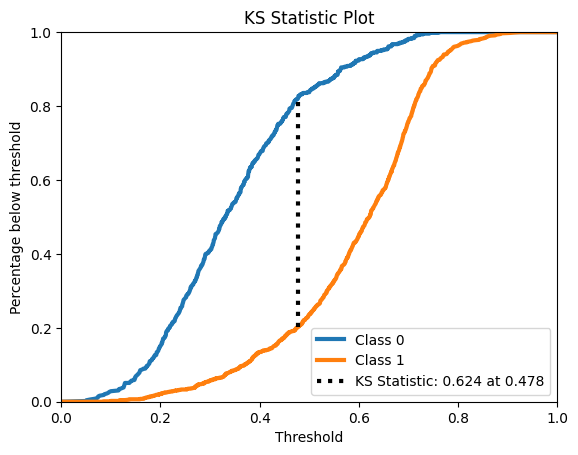

In [13]:
skplt.metrics.plot_ks_statistic(y_true=y_true_vgg, y_probas=y_probas_vgg)
plt.show()

In [14]:
from sklearn import metrics

results = [(labels, VGG.model.predict(images).reshape(-1)) for images, labels in test_data.take(-1)]

2023-04-17 03:45:20.197407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1399]
	 [[{{node Placeholder/_0}}]]
2023-04-17 03:45:20.197878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1399]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 5s 5s/step


##### Other metrics

In [15]:
labels = np.concatenate([x[0] for x in results])
preds = np.concatenate([x[1] for x in results])

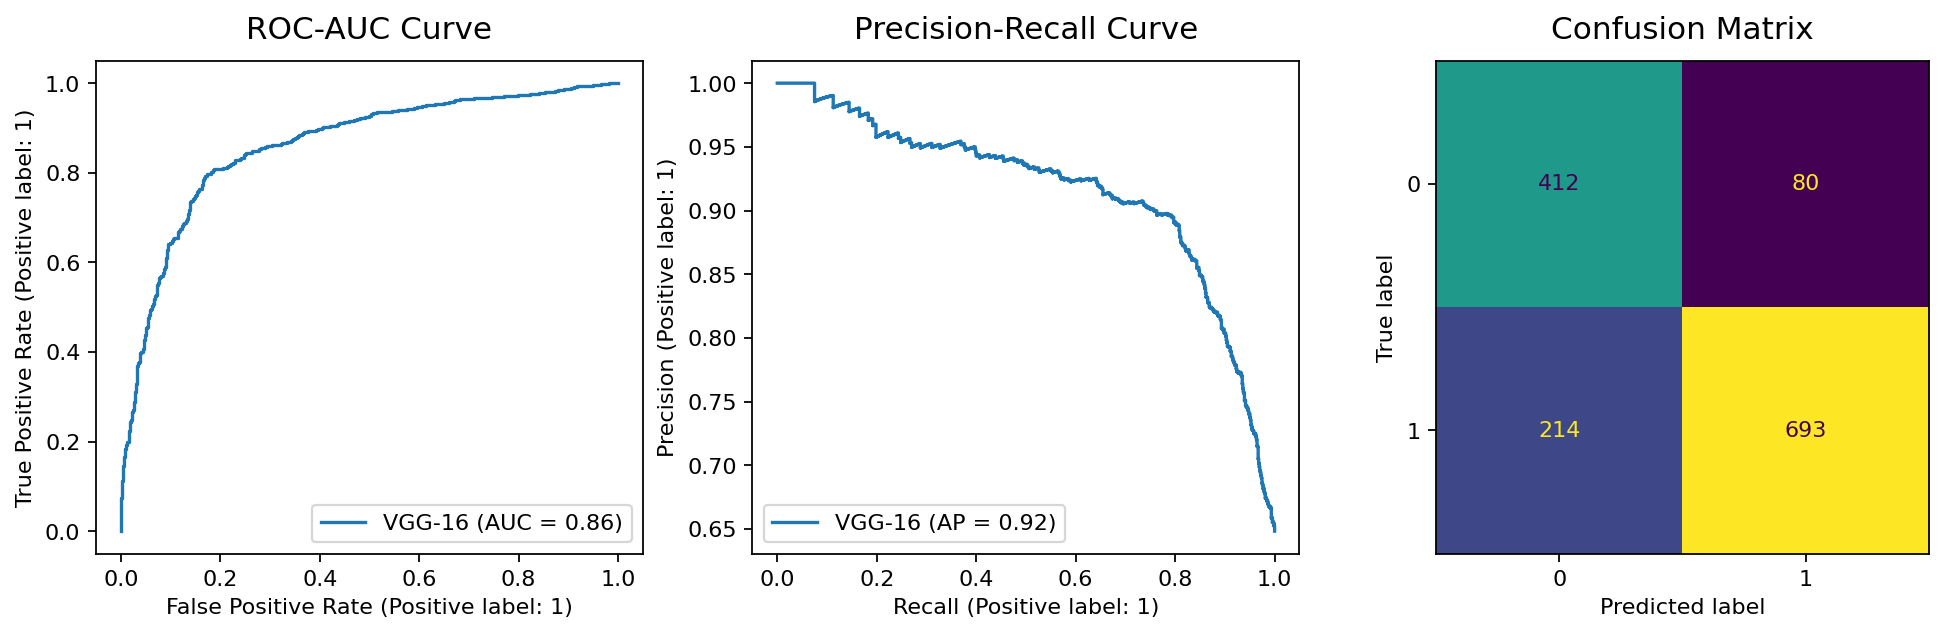

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
for ax, curve in zip(axes[:2], curves):
    curve.from_predictions(labels, preds, ax=ax, name='VGG-16')
metrics.ConfusionMatrixDisplay.from_predictions(
    labels, preds.round().astype('uint8'), ax=axes[2], colorbar=False,
)
titles = ['ROC-AUC Curve', 'Precision-Recall Curve', 'Confusion Matrix']
for ax, title in zip(axes.flat, titles):
    ax.set_title(title, size=14, pad=10)